In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 21 15:03:32 2023

@author: earyo
"""

#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *


#%%
''' this experiment investigate the influence 
of the ensemble size on the ENKF performance '''

##### for this experiment change the test period to a much shorter one
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'prepare_enkf', 'prepare_enkf2', 'run_enkf', and 'run_enkf2' are defined elsewhere

class Enkf_experiment5:
    
    def __init__(self, num_agents, macro_state_dim, repetitions, ensemble_size, uncertainty_in_models, uncertainty_obs_values, filter_frequency):
        self.num_agents = num_agents
        self.macro_state_dim = macro_state_dim
        self.repetitions = repetitions
        self.ensemble_size = ensemble_size
        self.uncertainty_obs_values = uncertainty_obs_values
        self.uncertainty_in_models = uncertainty_models
        self.filter_frequency = filter_frequency
        self.results_model1 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        self.results_model2 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        
    def run_experiment(self, start_year=1990, end_year=1993):
        
        #### set up result saving arrays
        #array_of_results_enkf1 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        #array_of_results_enkf2 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        
        
        
        #for idx, uncertainty_models in enumerate(tqdm(self.uncertainty_in_models)):
        for idx, uncertainty_models in enumerate(self.uncertainty_in_models): 
            #print(idx, uncertainty_models)
            #print("this is idx", uncertainty_models)
            

            model_params1 = {"population_size": 100,
                "growth_rate": 0.025,
                "b_begin": 1.3,
                "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                "start_year": start_year,
                "uncertainty_para": uncertainty_models[0]}
            

            model_params2 = {"population_size": 100, 
                "concavity": 1,
                "growth_rate": 0.025, 
                "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                "start_year": start_year,
                "adaptive_sensitivity": 0.02,
                "uncertainty_para": uncertainty_models[1]}
            
            for jdx, uncertainty_obs in enumerate(self.uncertainty_obs_values):
                
                    #print("this is jdx", uncertainty_obs)
                    #print(jdx, uncertainty_obs)
                
                    array_of_results_enkf1_repetitions = np.zeros((self.repetitions, 1))
                    array_of_results_enkf2_repetitions = np.zeros((self.repetitions, 1))
                    #print("this is shape", array_of_results_enkf1_repetitions.shape)
                    for i in range(self.repetitions):
                        
                        enkf1 = prepare_enkf(Model= Model1, model_params = model_params1, 
                                             ensemble_size=self.ensemble_size,
                                             macro_state_dim=self.macro_state_dim,
                                             uncertainty_obs=uncertainty_obs,
                                             filter_freq= self.filter_frequency)
                        
                        enkf2 = prepare_enkf(Model= Model2, model_params = model_params2,
                                             ensemble_size=self.ensemble_size, 
                                             macro_state_dim=self.macro_state_dim,
                                             uncertainty_obs=uncertainty_obs,
                                             filter_freq= self.filter_frequency)
                        
                        run_enkf(enkf1, start_year=start_year, end_year=end_year, filter_freq=10)
                        run_enkf(enkf2, start_year=start_year, end_year=end_year, filter_freq=10)
                        enkf1.make_macro_history_share()
                        enkf2.make_macro_history_share()
                        array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
                        array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
            
                        
                    #print("this is (np.mean(array_of_results_enkf1_repetitions))", np.mean(array_of_results_enkf1_repetitions))
                    #print("this is np.mean(array_of_results_enkf2_repetitions", np.mean(array_of_results_enkf2_repetitions))
                    print("this is idx, jdx", idx, jdx)
                    self.results_model1[idx, jdx] = np.mean(array_of_results_enkf1_repetitions) ## how this is setup idx goes down the rows, which means along the vertical dimension idx = model varies
                    self.results_model2[idx, jdx] = np.mean(array_of_results_enkf2_repetitions)
                            
             
    def plot_heatmap(self, results, model_name, ax=None, save_fig=False, fig_name='fig9.png'):
        # Define the levels of contours
        levels = np.linspace(np.min(results), np.max(results), num=200)
    
        # If an Axes object isn't provided, create a new figure and Axes
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
    
        # Create the contour plot on the provided Axes
        contour = ax.contourf(results, levels=levels, cmap='plasma', extend='neither')
        cbar = plt.colorbar(contour, ax=ax, label='Average Error', extend='neither')
        cbar.ax.set_ylabel('Average distance to Obs.', fontsize=13)
        
        # Set the labels for ticks if needed
        if model_name == 'Model1':
            labels_yaxis = [x[0] for x in self.uncertainty_in_models]
        elif model_name == 'Model2':
            labels_yaxis = [x[1] for x in self.uncertainty_in_models]
    
        ax.set_xticks(ticks=np.arange( len(self.uncertainty_obs_values)), labels=self.uncertainty_obs_values)
        ax.set_yticks(ticks=np.arange(len(self.uncertainty_in_models)), labels=labels_yaxis)
    
        # Set the labels and title
        ax.set_xlabel('Uncertainty data (Std. of wealth groups)', fontsize = 14) # see comment for self.results_model1
        if model_name == 'Model1':
            beta = r'\beta'
            ax.set_ylabel(f'Uncertainty in ${beta}$', fontsize=14)
        elif model_name == 'Model2':
            ax.set_ylabel('Perturbation in win probability', fontsize=14)
        ax.set_title(f'ENKF Performance Heatmap for {model_name}', fontsize = 14)
        
        # Save the figure if requested and if no specific Axes is provided
        if save_fig and ax is None:
            plt.savefig(f"{model_name}_{fig_name}", dpi=300)
    
        # Return the Axes object
        return ax

        
# Usage of the class
start_year = 1990
end_year = 1991


num_agents = 100
macro_state_dim = 4
repetitions = 10  # Example number of repetitions
ensemble_size = 20  # Example ensemble size
filter_frequency = 10
uncertainty_obs = [0.05, 0.1, 0.4, 0.8, 1] ###[0.01, 0.1, 0.5, 1] #[0.1, 0.5, 2, 10]  # Example values for uncertainty_obs
uncertainty_models = [(0.1, 0.1), (0.5, 0.2), (1, 0.5), (2, 0.8), (3, 1)]#[(0.1, 0.1), (0.2, 0.2), (0.5, 0.5), (0.8, 0.8)]
experiment = Enkf_experiment5(num_agents,
                              macro_state_dim,
                              repetitions, 
                              ensemble_size,
                              uncertainty_in_models = uncertainty_models,
                              uncertainty_obs_values = uncertainty_obs,
                              filter_frequency=filter_frequency)
experiment.run_experiment(start_year=start_year, end_year=end_year)

Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.97it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.60it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.97it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 0 0


Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 53.55it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  71%|███████   | 17/24 [00:00<00:00, 53.81it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.29it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 0 1


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 40.84it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 44.87it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.38it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 0 2


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.51it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.56it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your 

this is idx, jdx 0 3


Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 51.02it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  71%|███████   | 17/24 [00:00<00:00, 51.09it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.62it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 0 4


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.56it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 55.12it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.27it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 1 0


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 56.54it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 55.62it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.29it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 1 1


Iterations ENKF <class 'model1_class.Model1'>:  42%|████▏     | 10/24 [00:00<00:00, 34.42it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  67%|██████▋   | 16/24 [00:00<00:00, 40.80it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.16it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 1 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 35.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 22.38it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your 

this is idx, jdx 1 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 51.88it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.53it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your 

this is idx, jdx 1 4


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.59it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.74it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.06it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 2 0


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.17it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:00<00:00, 56.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.06it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 

this is idx, jdx 2 1


Iterations ENKF <class 'model1_class.Model1'>:  38%|███▊      | 9/24 [00:00<00:00, 36.99it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:00<00:00, 48.81it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.45it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 

this is idx, jdx 2 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 40.15it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 48.05it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.89it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 2 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.09it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.95it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.25it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 2 4


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.85it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 55.24it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.93it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 3 0


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.11it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 56.29it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 25.26it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 

this is idx, jdx 3 1


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 31.55it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 46.67it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 25.13it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 

this is idx, jdx 3 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 38.17it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 25.15it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your 

this is idx, jdx 3 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 57.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 41.50it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 25.26it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 3 4


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.42it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.94it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.82it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 4 0


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 56.67it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 55.33it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.27it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 4 1


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.01it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.76it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.62it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 4 2


Iterations ENKF <class 'model1_class.Model1'>:  42%|████▏     | 10/24 [00:00<00:00, 35.37it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.82it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your 

this is idx, jdx 4 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.35it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 41.01it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.24it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

this is idx, jdx 4 4



C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_41388\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


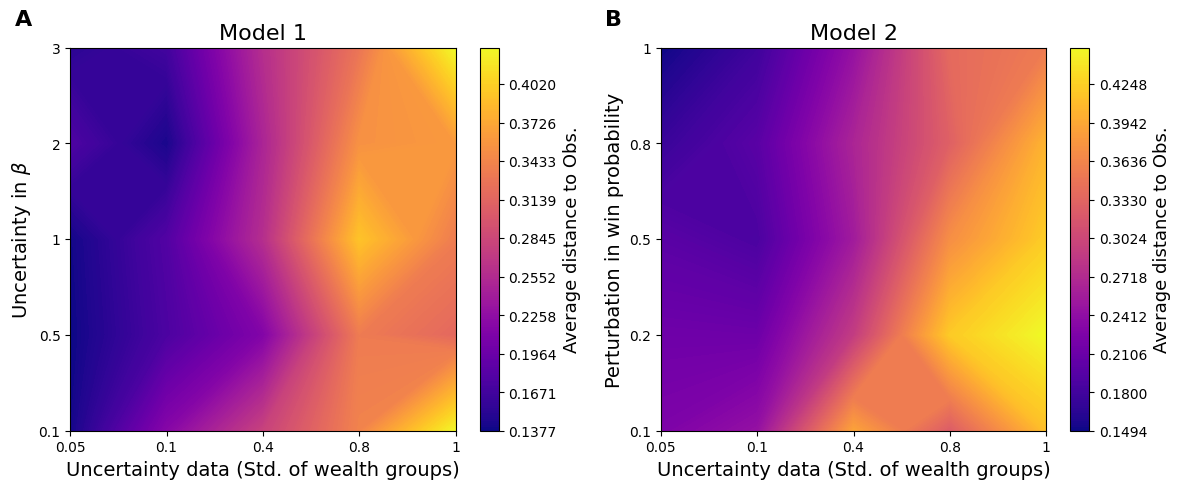

In [2]:
# Create a figure for the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot heatmap for Model 1 in the first subplot (ax1)
experiment.plot_heatmap(experiment.results_model1, "Model1", ax=ax1, save_fig=False)
ax1.set_title('Model 1', fontsize = 16)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot heatmap for Model 2 in the second subplot (ax2)
experiment.plot_heatmap(experiment.results_model2, "Model2", ax=ax2, save_fig=False)
ax2.set_title('Model 2', fontsize = 16)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the entire figure
plt.savefig('fig9.png', dpi=300)

# Show the plot
plt.show()